# Notebook: Approche Classique

## Mise en place

- Charger librairies
- Paramétrages utilisés

In [1]:
import os
import re
import cv2
import numpy as np

from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans 
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

- Compter nombre d'images par catégorie
- Rechercher images des 2, 6 et 12 catégories les plus nombreuses
- Extraire images des ces catégories, pour training/validation/testing sets
- Charger images en niveau de gris
- Resize en `200x200` pixels
- Assigner une catégorie cible

In [3]:
def load_images(n_categories):
    base_dir = 'Images'
    cat_counts = []

    for category in os.listdir(base_dir):
        if category.startswith('.'):
            continue
        cat_name = re.match(r"^n\d*-([\w\-]*)", category).groups()[0].title()
        cat_size = len(os.listdir(os.path.join(base_dir, category)))
        cat_counts.append((cat_name, cat_size))

    cat_counts = sorted(cat_counts, key=lambda x: x[1], reverse=True)
    for cat_name, cat_size in cat_counts[:n_categories]:
        print(f"{cat_name}: {cat_size}")
    print("")
    
    base_dir = 'data'
    train_data = []
    valid_data = []
    test_data = []
    sub_dirs = ['train', 'validation', 'test']

    for cat_name, _ in cat_counts[:n_categories]:
        for sub_dir, sub_list in zip(sub_dirs, [train_data, valid_data, test_data]):
            cat_path = os.path.join(base_dir, sub_dir, cat_name)
            for image_file in os.listdir(cat_path):
                image_path = os.path.join(cat_path, image_file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # load in grayscale
                image = cv2.resize(image, (200, 200)) # resize
                sub_list.append((image, cat_name))

    train_images, train_labels = zip(*shuffle(train_data))
    valid_images, valid_labels = zip(*shuffle(valid_data))

    cv_images, cv_labels = train_images + valid_images, train_labels + valid_labels
    test_images, test_labels = zip(*shuffle(test_data))
    
    return cv_images, test_images, cv_labels, test_labels

In [4]:
train_images, test_images, train_labels, test_labels = load_images(2)
train_images_6, test_images_6, train_labels_6, test_labels_6 = load_images(6)
train_images_12, test_images_12, train_labels_12, test_labels_12 = load_images(12)

Maltese_Dog: 252
Afghan_Hound: 239

Maltese_Dog: 252
Afghan_Hound: 239
Scottish_Deerhound: 232
Pomeranian: 219
Irish_Wolfhound: 218
Bernese_Mountain_Dog: 218

Maltese_Dog: 252
Afghan_Hound: 239
Scottish_Deerhound: 232
Pomeranian: 219
Irish_Wolfhound: 218
Bernese_Mountain_Dog: 218
Samoyed: 218
Shih-Tzu: 214
Great_Pyrenees: 213
Leonberg: 210
Basenji: 209
Tibetan_Terrier: 206



- Afficher un exemple de photos

Maltese_Dog


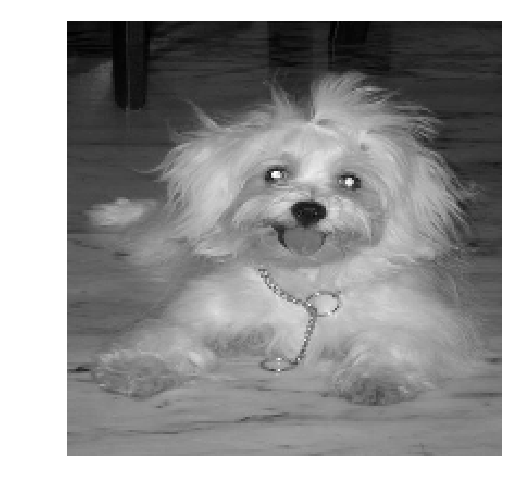

In [5]:
sample = np.random.randint(0, len(train_images))
plt.imshow(train_images[sample], cmap='gray')
plt.axis('off');
print(train_labels[sample])

- Adapter les images et labels au format attendus par classifieurs

In [5]:
def prepare_data(train_images, test_images, train_labels, test_labels, filtre=None):
    
    if filtre:
        train_images = [filtre(image) for image in train_images]
        test_images = [filtre(image) for image in test_images]
    
    # Adapt inputs: flatten image arrays
    train_images = np.array(train_images)
    nsamples, nx, ny = train_images.shape
    X_train = train_images.reshape((nsamples,nx*ny))

    test_images = np.array(test_images)
    nsamples, nx, ny = test_images.shape
    X_test = test_images.reshape((nsamples,nx*ny))

    # Adapt targets: encode labels
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(train_labels)
    y_test = encoder.transform(test_labels)
    
    return X_train, X_test, y_train, y_test

## Approche n°1:  intensité des pixels

### Valeurs brutes

- Préparer les données

In [6]:
X_train, X_test, y_train, y_test = prepare_data(train_images, test_images, train_labels, test_labels)
X_train_6, X_test_6, y_train_6, y_test_6 = prepare_data(train_images_6, test_images_6, train_labels_6, test_labels_6)
X_train_12, X_test_12, y_train_12, y_test_12 = prepare_data(train_images_12, test_images_12, train_labels_12, test_labels_12)

- Trouver meilleure pénalisation pour modèle de régression linéaire
- Score sur test set pour 2, 6 et 12 catégories

In [7]:
def def_grid_pixels():
    hyperparameters = {'C': [1.0, 10, 30]}
    estimator = LogisticRegression()
    
    grid_pixels = GridSearchCV(estimator, hyperparameters, iid=False, scoring='accuracy',
                               n_jobs=-1, verbose=1)
    
    return grid_pixels

In [32]:
grid_pixels_2 = def_grid_pixels()
grid_pixels_2.fit(X_train, y_train)
print(f"Test accuracy with 2 classes: {round(grid_pixels_2.score(X_test, y_test)*100, 2)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   34.4s finished


Test accuracy with 2 classes: 73.74


In [33]:
grid_pixels_6 = def_grid_pixels()
grid_pixels_6.fit(X_train_6, y_train_6)
print(f"Test accuracy with 6 classes: {round(grid_pixels_6.score(X_test_6, y_test_6)*100, 2)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 12.1min finished


Test accuracy with 6 classes: 30.07


In [8]:
grid_pixels_12 = def_grid_pixels()
grid_pixels_12.fit(X_train_12, y_train_12)
print(f"Test accuracy with 12 classes: {round(grid_pixels_12.score(X_test_12, y_test_12)*100, 2)}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed: 22.5min remaining: 28.2min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 28.5min finished


Test accuracy with 12 classes: 13.42


### Réduction de dimension

- Trouver meilleur pénalisation de régression linéaire, et meilleur nombre de composantes à garder avec PCA
- Score sur test set pour 2, 6 et 12 catégories

In [8]:
def def_grid_pca():
    hyperparameters = {'clf__C': [1.0, 10, 30],
                       'pca__n_components': [0.85, 0.95]
                      }
    estimator = Pipeline([('pca', PCA(whiten=True)),
                          ('clf', LogisticRegression(max_iter=10000))
                         ])
    
    grid_pca = GridSearchCV(estimator, hyperparameters, scoring='accuracy', 
                            iid=False, n_jobs=1, verbose=1)
    
    return grid_pca

In [9]:
grid_pca_2 = def_grid_pca()
grid_pca_2.fit(X_train, y_train)
print(f"Test accuracy with 2 classes: {round(grid_pca_2.score(X_test, y_test)*100, 2)}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   12.8s finished


Test accuracy with 2 classes: 70.71


In [10]:
grid_pca_6 = def_grid_pca()
grid_pca_6.fit(X_train_6, y_train_6)
print(f"Test accuracy with 6 classes: {round(grid_pca_6.score(X_test_6, y_test_6)*100, 2)}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.3min finished


Test accuracy with 6 classes: 30.43


In [11]:
grid_pca_12 = def_grid_pca()
grid_pca_12.fit(X_train_12, y_train_12)
print(f"Test accuracy with 12 classes: {round(grid_pca_12.score(X_test_12, y_test_12)*100, 2)}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  4.2min finished


Test accuracy with 12 classes: 15.88


---
**Bilan de performance de l'approche n°1**


| # classes | Pixels brutes | PCA Whitening |
| --- | --- | --- |
| 2 | 73.74 | 70.71 |
| 6 | 30.07 | 30.43 |
| 12 | 13.42 | 15.88 |

## Approche n°2: détection de contours

- Filtres pour trouver ces contours (Sobel, Canny)

In [12]:
def edges_sobel(image):
    image_x = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    image_y = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    
    image_x = np.uint8(np.absolute(image_x))
    image_y = np.uint8(np.absolute(image_y))
    image_sobel = cv2.bitwise_or(image_x, image_y)
    
    return image_sobel


def edges_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
 
    return edged

- Exemple d'application

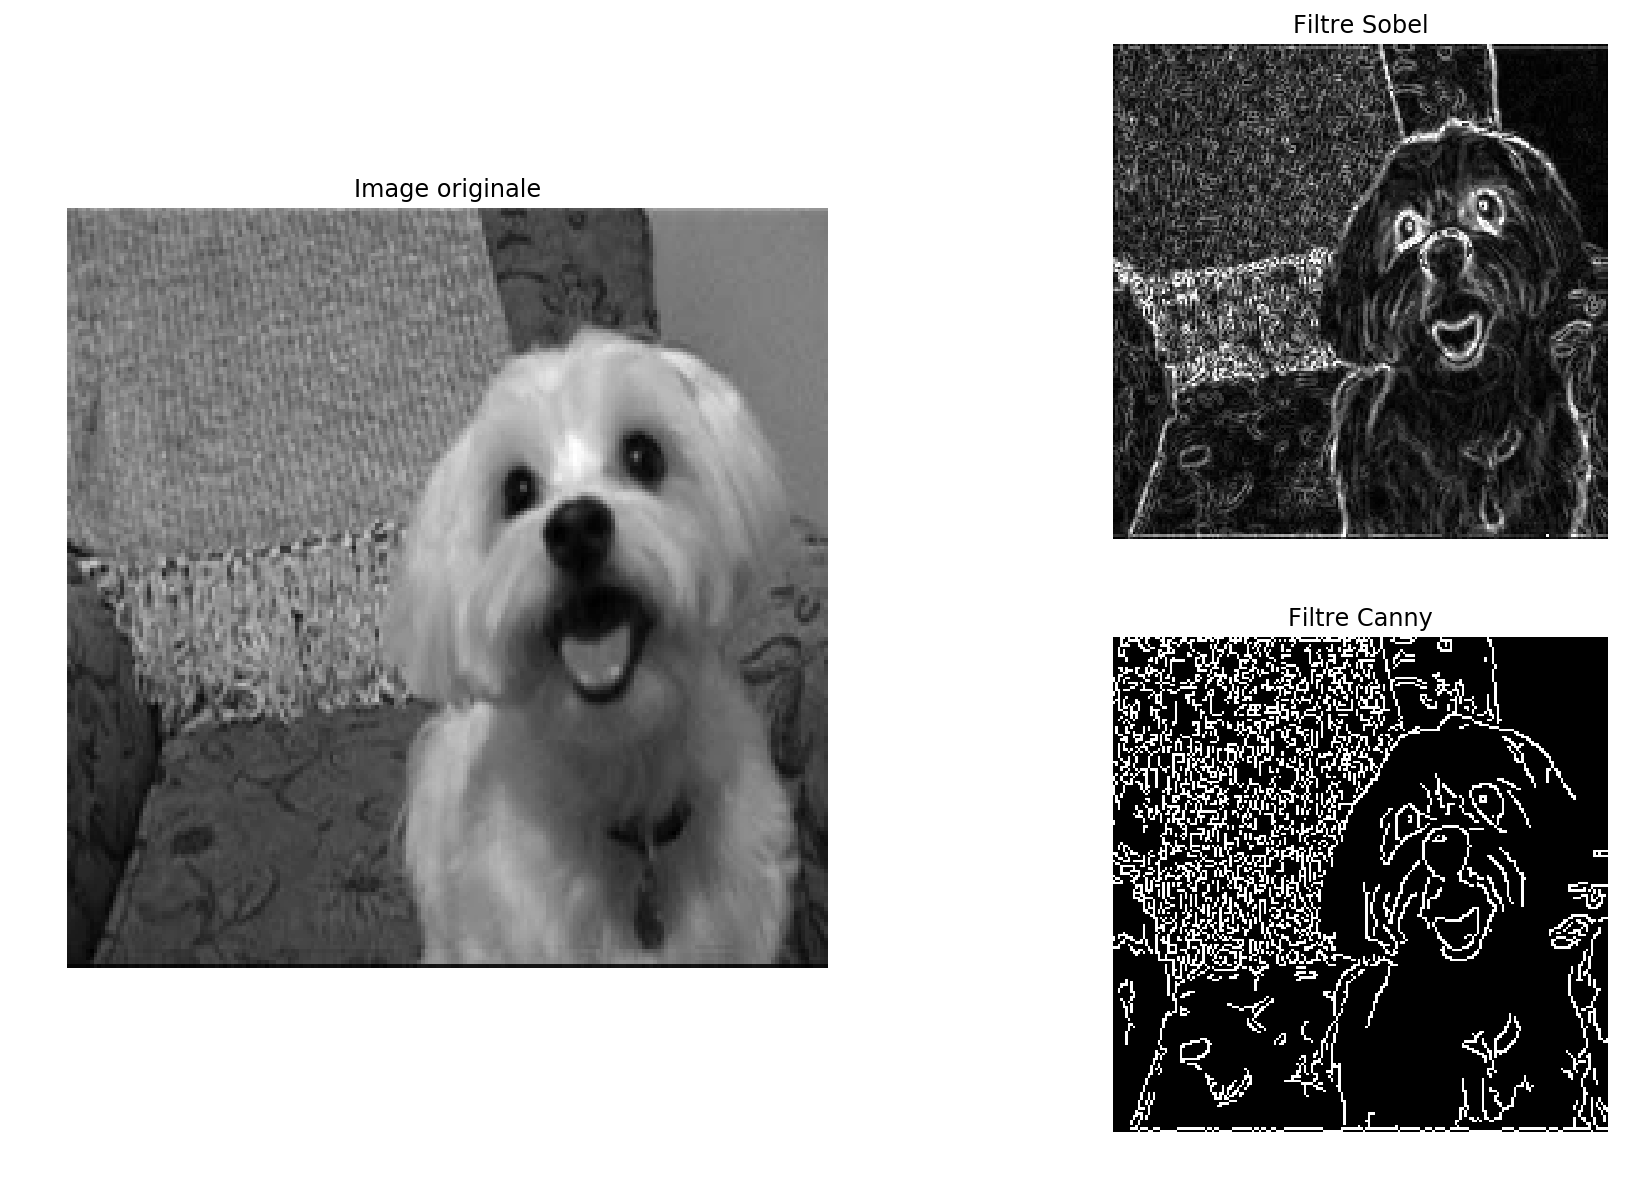

In [15]:
# Process images
sample = np.random.randint(0, len(train_images))
my_image = train_images[sample]
image_sobel = edges_sobel(my_image)
image_canny = edges_canny(my_image)

# Plot
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(gs[:, 0])
ax1.imshow(my_image, cmap='gray')
ax1.set_title('Image originale')
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(image_sobel, cmap='gray')
ax2.set_title('Filtre Sobel')
ax2.axis('off')

ax3 = fig.add_subplot(gs[1, 1])
ax3.imshow(image_canny, cmap='gray')
ax3.set_title('Filtre Canny')
ax3.axis('off');

### Filtre sobel

- Préparer les données en appliquant le filtre Sobel

In [24]:
X_train, X_test, y_train, y_test = prepare_data(train_images, test_images, 
                                                train_labels, test_labels, edges_sobel)
X_train_6, X_test_6, y_train_6, y_test_6 = prepare_data(train_images_6, test_images_6, 
                                                        train_labels_6, test_labels_6, edges_sobel)
X_train_12, X_test_12, y_train_12, y_test_12 = prepare_data(train_images_12, test_images_12, 
                                                            train_labels_12, test_labels_12, edges_sobel)

- Trouver meilleur modèle
- Score sur test set pour 2, 6 et 12 catégories

In [25]:
grid_sobel_2 = def_grid_pca()
grid_sobel_2.fit(X_train, y_train)
print(f"Test accuracy with 2 classes: {round(grid_sobel_2.score(X_test, y_test)*100, 2)}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   14.6s finished


Test accuracy with 2 classes: 72.73


In [26]:
grid_sobel_6 = def_grid_pca()
grid_sobel_6.fit(X_train_6, y_train_6)
print(f"Test accuracy with 6 classes: {round(grid_sobel_6.score(X_test_6, y_test_6)*100, 2)}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.5min finished


Test accuracy with 6 classes: 26.45


In [27]:
grid_sobel_12 = def_grid_pca()
grid_sobel_12.fit(X_train_12, y_train_12)
print(f"Test accuracy with 12 classes: {round(grid_sobel_12.score(X_test_12, y_test_12)*100, 2)}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  4.6min finished


Test accuracy with 12 classes: 14.56


### Filtre canny

- Préparer les données en appliquant le filtre Canny

In [28]:
X_train, X_test, y_train, y_test = prepare_data(train_images, test_images, 
                                                train_labels, test_labels, edges_canny)
X_train_6, X_test_6, y_train_6, y_test_6 = prepare_data(train_images_6, test_images_6, 
                                                        train_labels_6, test_labels_6, edges_canny)
X_train_12, X_test_12, y_train_12, y_test_12 = prepare_data(train_images_12, test_images_12, 
                                                            train_labels_12, test_labels_12, edges_canny)

- Trouver meilleur modèle
- Score sur test set pour 2, 6 et 12 catégories

In [29]:
grid_canny_2 = def_grid_pca()
grid_canny_2.fit(X_train, y_train)
print(f"Test accuracy with 2 classes: {round(grid_canny_2.score(X_test, y_test)*100, 2)}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   13.2s finished


Test accuracy with 2 classes: 69.7


In [30]:
grid_canny_6 = def_grid_pca()
grid_canny_6.fit(X_train_6, y_train_6)
print(f"Test accuracy with 6 classes: {round(grid_canny_6.score(X_test_6, y_test_6)*100, 2)}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.5min finished


Test accuracy with 6 classes: 24.64


In [31]:
grid_canny_12 = def_grid_pca()
grid_canny_12.fit(X_train_12, y_train_12)
print(f"Test accuracy with 12 classes: {round(grid_canny_12.score(X_test_12, y_test_12)*100, 2)}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  5.1min finished


Test accuracy with 12 classes: 11.34


---
**Bilan de performance de l'approche n°2** 

| # classes | Filtre Sobel | Filtre Canny
| --- | --- | --- |
| 2 | 72.73 | 69.7 |
| 6 | 26.45 | 24.64 |
| 12 | 14.56 | 11.34 |

## Approche n°3: détection et extraction de caractéristiques avec SIFT

- Exemple d'application à une image

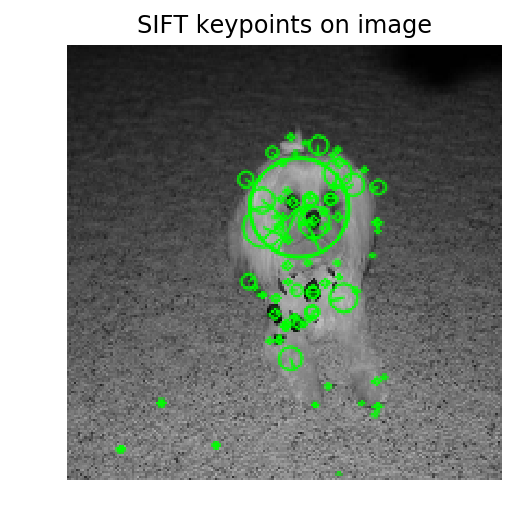

In [9]:
sample = np.random.randint(0, len(train_images))
my_image = train_images[sample]
sift = cv2.xfeatures2d.SIFT_create(100)
kp, des = sift.detectAndCompute(my_image, None)

sift_image = cv2.drawKeypoints(my_image, kp, None, (0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(sift_image)
plt.title("SIFT keypoints on image")
plt.axis('off');

In [5]:
class ImageQuantizer():

    def __init__(self, extractor, normalize_descriptors=False):
        self.extractor = extractor
        self.normalize_descriptors = normalize_descriptors
        self.words_scaler = None
        self.codebooks = None

    def extract_descriptors(self, images, training=False):
        """
        Extract descriptors of images with assigned descriptor
        """
        list_desc = []
        for image in images:
            _, desc = self.extractor.detectAndCompute(image, None)
            list_desc.append(desc)
        descriptors = np.vstack(list_desc)

        if self.normalize_descriptors:
            if training:
                scaler = MinMaxScaler()
                descriptors = scaler.fit_transform(descriptors)
                self.words_scaler = scaler
            else:
                descriptors = self.words_scaler.transform(descriptors)

        return descriptors

    def train_codebook(self, images, min_k, max_k, step=1):
        """
        Chercher meilleur modèle pour codebook
        """
        distortions = []
        models = []
        descriptors = self.extract_descriptors(images, training=True)

        for n, k in enumerate(range(min_k, max_k, step)):
            km = KMeans(n_clusters=k, max_iter=1000, n_jobs=1)
            km.fit(descriptors)
            distortions.append(km.inertia_)
            models.append(km)
            print(k)

        plt.plot(range(min_k, max_k, step), distortions, marker='o')
        plt.xlabel('Nombres de clusters')
        plt.ylabel('Distortion intra-groupes')
        plt.show();

        self.codebooks = models

    def find_BoVW(self, images, n_model, normalize=False):
        """
        Créer les bag of visual words
        """
        if not self.codebooks:
            raise Exception('Codebooks not trained')
            
        codebook = self.codebooks[n_model]
        features = []
        for image in images:
            descriptors = self.extract_descriptors([image])
            fv = np.zeros(codebook.n_clusters)
            words = codebook.predict(descriptors)
            for word in words:
                fv[word] += 1

            if normalize:
                features.append(fv / fv.sum())
            else:
                features.append(fv)

        return np.vstack(features)

- Extraction des points remarquables et construction des *bag-of-words* visuels

In [6]:
max_descriptors = 100
extractor = cv2.xfeatures2d.SIFT_create(max_descriptors)

4
6
8
10
12
14
16
18
20


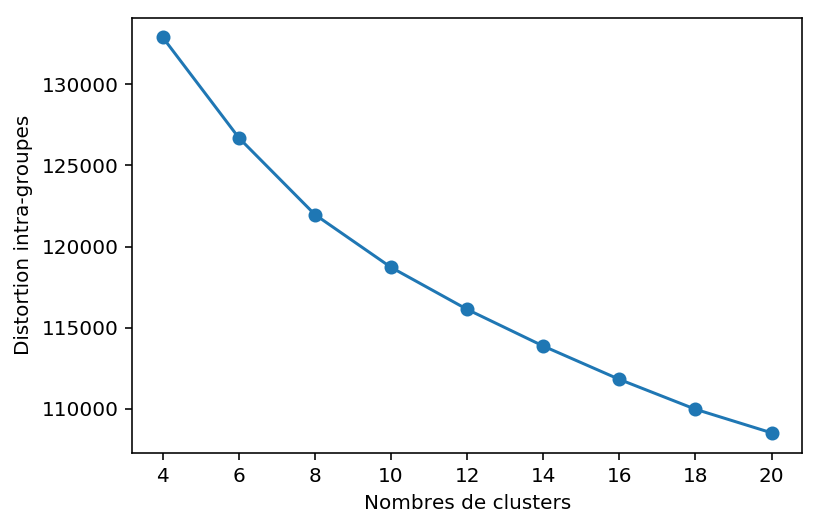

In [7]:
start, end, step = 4, 21, 2
sift_quant_2 = ImageQuantizer(extractor, normalize_descriptors=True)
sift_quant_2.train_codebook(train_images, start, end, step)

10
20
30
40
50
60
70
80
90
100


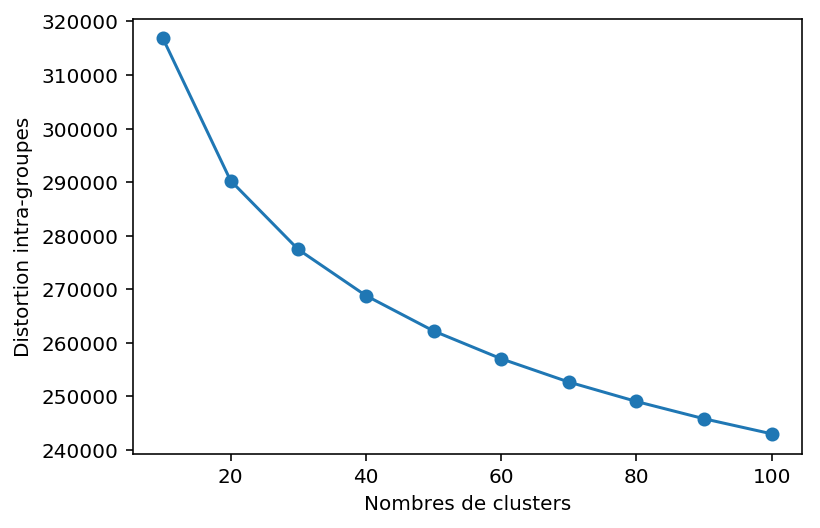

In [8]:
start, end, step = 10, 101, 10
sift_quant_6 = ImageQuantizer(extractor, normalize_descriptors=True)
sift_quant_6.train_codebook(train_images_6, start, end, step)

20
40
60
80
100
120
140
160
180
200


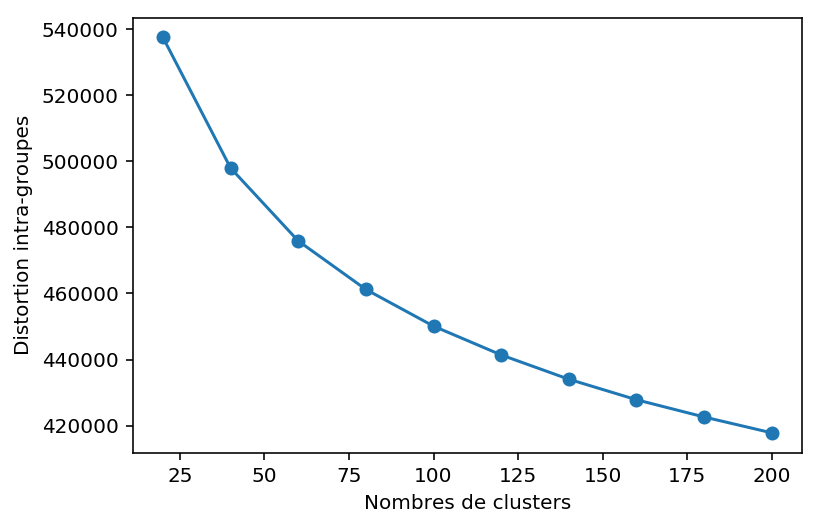

In [9]:
start, end, step = 20, 201, 20
sift_quant_12 = ImageQuantizer(extractor, normalize_descriptors=True)
sift_quant_12.train_codebook(train_images_12, start, end, step)

- Préparation des données: assigner chaque descripteur de chaque image à son `word` le plus proche dans notre *bag_of_words* visuel créé, et compter le nombre d'instance de chaque `word` pour chaque image. Ces données seront passées au modèle pour entrainement et évaluation

In [10]:
def prepare_sift(train_images, test_images, train_labels, test_labels, sift, normalize=True, n_model=-1):
    X_train = sift.find_BoVW(train_images, n_model=n_model, normalize=normalize)
    X_test = sift.find_BoVW(test_images, n_model=n_model, normalize=normalize)
    
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(train_labels)
    y_test = encoder.transform(test_labels)
    
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = prepare_sift(train_images, test_images, 
                                                train_labels, test_labels, 
                                                sift_quant_2, n_model=8)

In [24]:
X_train_6, X_test_6, y_train_6, y_test_6 = prepare_sift(train_images_6, test_images_6, 
                                                        train_labels_6, test_labels_6, 
                                                        sift_quant_6, n_model=4)

In [22]:
X_train_12, X_test_12, y_train_12, y_test_12 = prepare_sift(train_images_12, test_images_12, 
                                                            train_labels_12, test_labels_12, 
                                                            sift_quant_12, n_model=-1)

- Classification pour 2, 6 et 12 classes

In [12]:
def def_grid_sift():
    hyperparameters = {'C': [1.0, 10, 30]}
    estimator = LinearSVC(max_iter=100000)

    grid_sift = GridSearchCV(estimator, hyperparameters, iid=False, scoring='accuracy', 
                             n_jobs=1, cv=10, verbose=1)
    
    return grid_sift

In [13]:
grid_sift = def_grid_sift()
grid_sift.fit(X_train, y_train)
print(f"Test accuracy with 2 classes: {round(grid_sift.score(X_test, y_test)*100, 2)}")

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Test accuracy with 2 classes: 74.75


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished


In [25]:
grid_sift_6 = def_grid_sift()
grid_sift_6.fit(X_train_6, y_train_6)
print(f"Test accuracy with 6 classes: {round(grid_sift_6.score(X_test_6, y_test_6)*100, 2)}")

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Test accuracy with 6 classes: 37.32


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    8.4s finished


In [23]:
grid_sift_12 = def_grid_sift()
grid_sift_12.fit(X_train_12, y_train_12)
print(f"Test accuracy with 12 classes: {round(grid_sift_12.score(X_test_12, y_test_12)*100, 2)}")

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Test accuracy with 12 classes: 22.5


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   38.7s finished


---
**Bilan de performance global des méthodes classiques**

| # classes | Pixels brutes | PCA Whitening | Filtre Sobel | Filtre Canny | SIFT
| --- | --- | --- | --- | ----
| 2 | 73.74 | 70.71 | 72.73 | 69.70 | **74.75**
| 6 | 30.07 | 30.43 | 26.45 | 24.64 | **37.32**
| 12 | 13.42 | 15.88 | 14.56 | 11.34 | **22.50**